In [1]:
%%time
import pandas as pd
import numpy as np
import sys
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
from copy import deepcopy,copy
from ipywidgets import IntProgress
from itertools import chain
from IPython.display import display
from datetime import datetime
import pickle
import os
# Since the 'user' column do not have relevant information will not be read

# Import Machine Scientist
from importlib.machinery import SourceFileLoader
path = '/export/home/shared/Projects/City_flows/rguimera-machine-scientist/machinescientist.py'
ms = SourceFileLoader('ms', path).load_module()

# Read data
states=['New York','Massachusetts','California','Florida','Washington','Texas']
scatter_models_A={s:{} for s in states}#dict.fromkeys(states,{})
scatter_models_B={s:{} for s in states}#dict.fromkeys(states,{})
scatter_models_C={s:{} for s in states}
error_models_A={s:{} for s in states}#dict.fromkeys(states,{})
error_models_B={s:{} for s in states}#dict.fromkeys(states,{})
error_models_C={s:{} for s in states}

CPU times: user 1.02 s, sys: 1.43 s, total: 2.46 s
Wall time: 703 ms


In [2]:
name=open('./repository/data/checkpoints/fold1_sample_dataframes_2022_11_02-02_54_03.pkl', "rb")
sample_train=pickle.load(name)
name.close()
#
name=open('./repository/data/checkpoints/fold2_dataframes_2022_11_02-02_54_03.pkl', "rb")
test=pickle.load(name)
name.close()
#
name=open('./repository/data/checkpoints/list_states_dataframes_2022_11_02-02_53_58.pkl', "rb")
list_states_dataframes=pickle.load(name)
name.close()


#
train_list_dataframes=sample_train
#
test_list_dataframes=test
#
x_train_list_sample=deepcopy(sample_train)
#
y_train_list_sample=deepcopy({key:item['total_pop_flow'] for key,item in sample_train.items()})

In [3]:
display(train_list_dataframes['New York'])

,name_o,name_d,total_pop_flow,d,s,area_o,area_d,m_o,m_d,food_point_o,...,commercial_landuse_d,retail_point_d,retail_poly_d,school_point_d,school_poly_d,transport_point_d,transport_poly_d,entertainment_point_d,entertainment_poly_d,sk
14594,Jefferson Valley-Yorktown,Heritage Hills,87.0,8.604705,14828.0,18.023643,4.833175,14444,4511,0,...,0,0,0.000000,0,0.000000,1,0.000906,0,0.000000,554.0
10842,Coram,Syosset,401.0,42.363684,1431584.0,35.809365,12.885287,40220,19259,6,...,3,255,0.678554,35,0.682843,41,0.165103,65,0.625437,4032785.0
14394,Islip,Garden City,508.0,36.177391,2047849.0,12.292964,13.799905,18418,23272,17,...,8,69,3.599027,60,0.780191,211,0.504270,171,2.471141,7720250.0
12424,Franklin Square,Huntington Bay,64.0,31.783607,10911308.0,7.458918,2.585393,30903,1446,47,...,0,2,0.000775,0,0.000000,1,0.001903,8,0.282326,12049922.0
14749,Kings Park,Copiague,111.0,27.087126,1289844.0,17.279484,8.008831,17085,23429,5,...,0,360,0.266450,8,0.269888,29,0.125342,45,0.748283,4055938.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17321,Montrose,White Plains,288.0,28.857968,619440.0,4.196753,25.217999,2862,59559,0,...,0,38,0.239746,26,0.537062,181,0.624287,166,2.611916,851773.0
3220,Rockville Centre,Floral Park,149.0,8.444871,515735.0,8.419755,3.680302,26016,16172,68,...,2,174,0.603303,11,0.245779,43,0.046144,42,2.227920,2428787.0
14736,Kings Park,Huntington Bay,493.0,14.120643,432640.0,17.279484,2.585393,17085,1446,5,...,0,2,0.000775,0,0.000000,1,0.001903,8,0.282326,1349704.0
9318,Bayport,Harrison,57.0,63.702423,2854110.0,9.675302,43.422937,8609,28218,1,...,0,13,0.055598,39,3.808395,178,4.051248,137,6.448536,10648244.0


5952 5952
1180 1180
11727 11727
7092 7092
2083 2083
2782 2782


"Rad = pd.DataFrame(res,index=[['Radiation', 'Radiation', 'Radiation', 'Radiation', 'Radiation', 'Radiation'],\n                                   ['CPC', 'ACC', 'RMSE','RE','LR','DL(train)']])\ndisplay(Rad)"

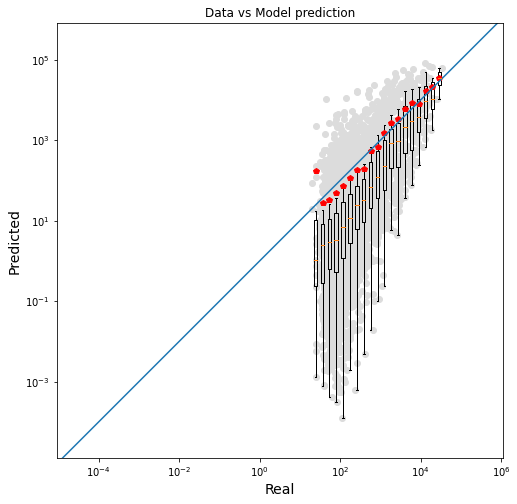

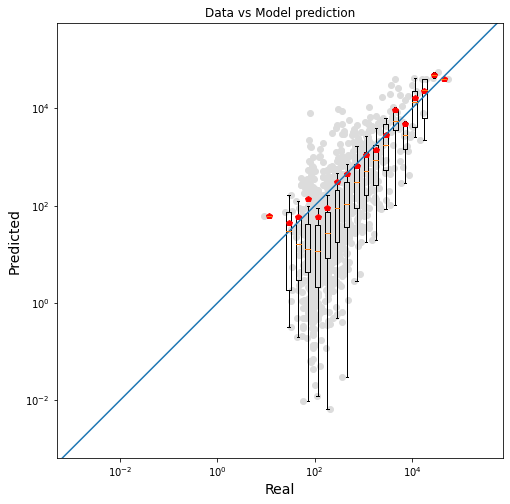

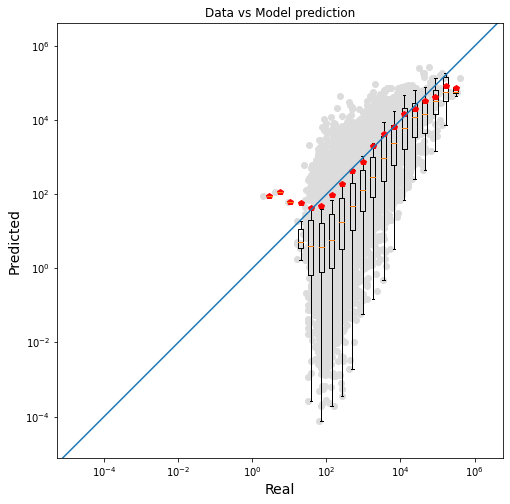

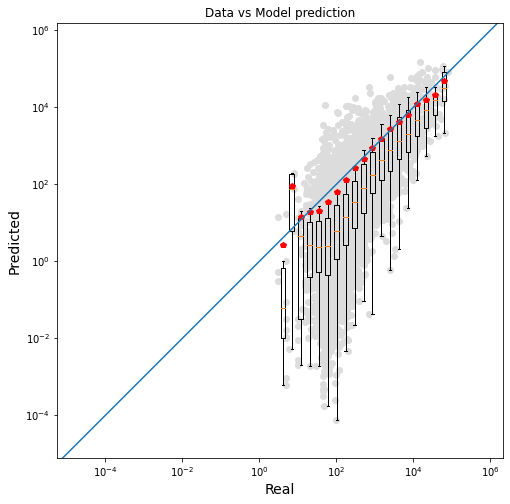

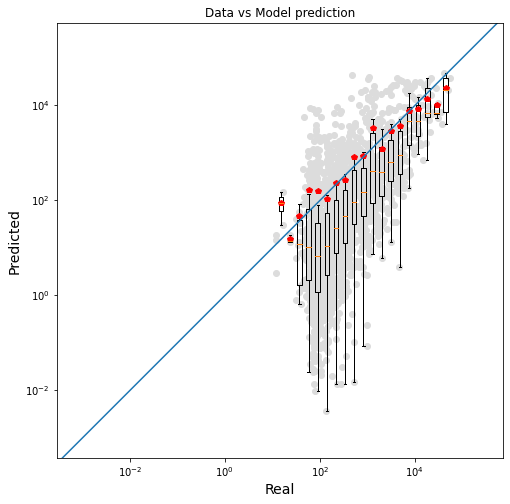

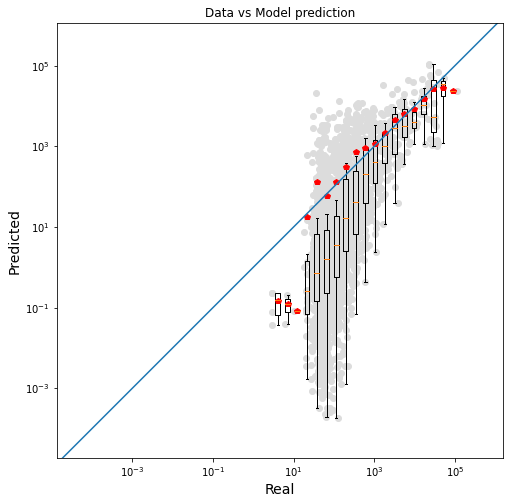

In [4]:
log_flows=False
res={}
def radiation_model(dataset,row):
    row=row[1]
    origin=row.name_o
    T_i=np.sum(dataset[dataset.name_o==origin].total_pop_flow.values)
    R=T_i*(row.m_o*row.m_d)/((row.m_o+row.s)*(row.m_o+row.m_d+row.s))
    #R=T_i*((1/(1.+(row.s/row.m_o)))-(1/(1.+((row.s+row.m_d)/row.m_o))))
    if log_flows==True:
        return np.log(R)
    else:
        return R
for i,(key,df) in enumerate(test_list_dataframes.items()):
    test_labels=[]
    predictions=[]
    for row in df.iterrows():
        test_labels.append(row[1].total_pop_flow)
        predictions.append(radiation_model(list_states_dataframes[i],row))
    if log_flows==True:
        predictions=np.exp(predictions)
    print(len(test_labels),len(predictions))
    res[key]=predictions
    """scatter_models_A[key]['Radiation']=deepcopy(predictions)
    scatter_models_B[key]['Radiation']=deepcopy(predictions)
    scatter_models_C[key]['Radiation']=deepcopy(predictions)
    res[key]=[common_part_of_commuters(test_labels,predictions),
              common_part_of_commuters_accuracy(test_labels,predictions),
              RMSE(test_labels,predictions),
              MRE(test_labels,predictions),
              MLogRatio(test_labels,predictions),
              '-'
             ]
    error_models_A[key]['Radiation']={'AbsErr':deepcopy(AbsErr(test_labels,predictions)),
                                          'RE':deepcopy(RE(test_labels,predictions)),
                                          'LogRatio':deepcopy(LogRatio(test_labels,predictions))
                                         }
    error_models_B[key]['Radiation']={'AbsErr':deepcopy(AbsErr(test_labels,predictions)),
                                          'RE':deepcopy(RE(test_labels,predictions)),
                                          'LogRatio':deepcopy(LogRatio(test_labels,predictions))
                                         }
    error_models_C[key]['Radiation']={'AbsErr':deepcopy(AbsErr(test_labels,predictions)),
                                          'RE':deepcopy(RE(test_labels,predictions)),
                                          'LogRatio':deepcopy(LogRatio(test_labels,predictions))
                                         }
    economic_stats[key]['Radiation']=predictions
   
    print(f'Model metrics:{key}')
    print('CPC:',res[key][0])
    print('Acc:',res[key][1])
    print('RMSE:',res[key][2])
    print('RE:',res[key][3])
    print('DL(train):',res[key][4])
    test_labels,predictions=delete_nan(test_labels,predictions)"""
    ms.plot_predicted_model(prediction=predictions,real=test_labels,title="Data vs Model prediction",n_box=20,log_scale=True)

"""Rad = pd.DataFrame(res,index=[['Radiation', 'Radiation', 'Radiation', 'Radiation', 'Radiation', 'Radiation'],
                                   ['CPC', 'ACC', 'RMSE','RE','LR','DL(train)']])
display(Rad)"""

15364969.0
5952 5952
4687088.0
1180 1180
35272825.0
11727 11727
14537971.0
7092 7092
5586405.0
2083 2083
19593571.0
2782 2782


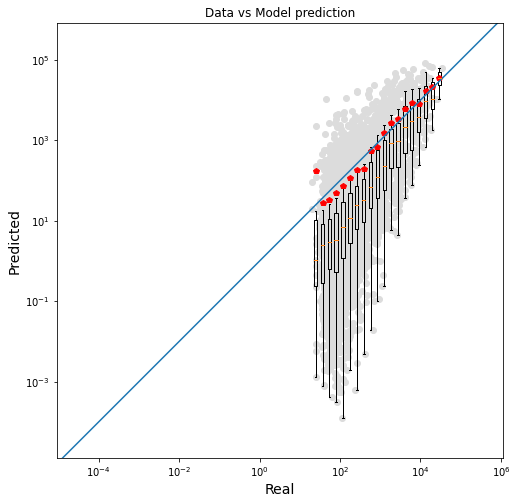

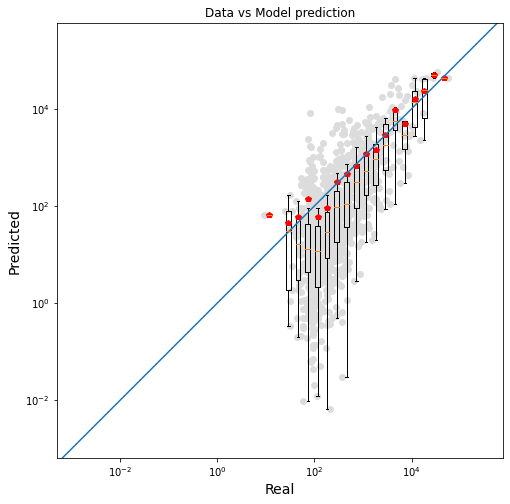

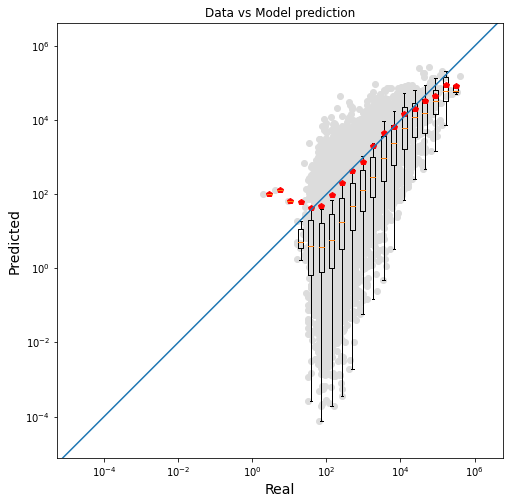

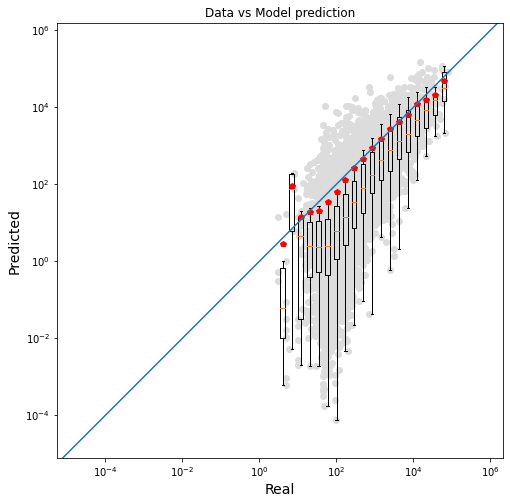

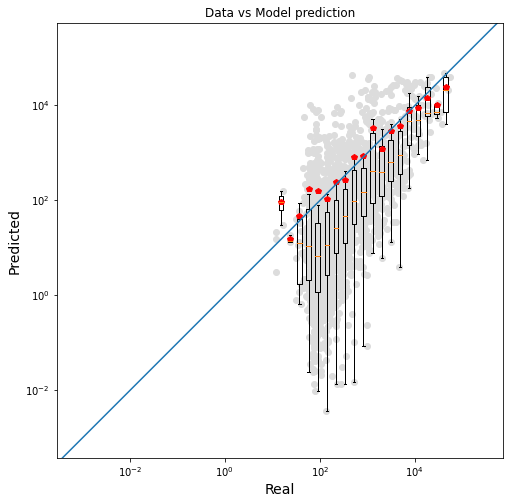

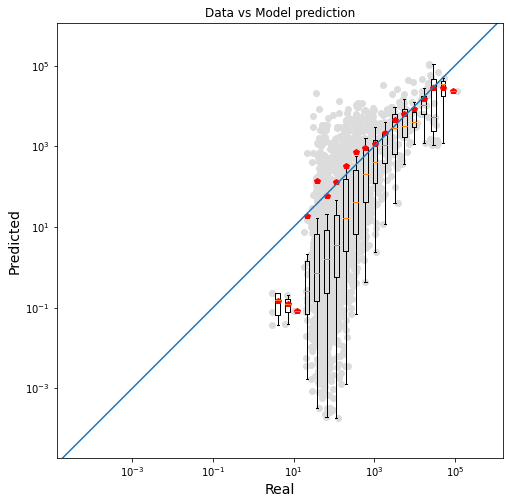

In [5]:
res1={}
def radiation_model(dataset,row,M):
    row=row[1]
    origin=row.name_o
    T_i=np.sum(dataset[dataset.name_o==origin].total_pop_flow.values)
    R=T_i*(row.m_o*row.m_d)/((row.m_o+row.s)*(row.m_o+row.m_d+row.s))/(1.-row.m_o/M)
    #R=T_i*((1/(1.+(row.s/row.m_o)))-(1/(1.+((row.s+row.m_d)/row.m_o))))
    if log_flows==True:
        return np.log(R)
    else:
        return R
for i,(key,df) in enumerate(test_list_dataframes.items()):
    test_labels=[]
    predictions=[]
    m1=list_states_dataframes[i][['name_o','m_o']].drop_duplicates(subset = "name_o")
    m2=list_states_dataframes[i][['name_d','m_d']].drop_duplicates(subset = "name_d")
    MM=pd.concat([m1.rename(columns={'name_o': 'name','m_o': 'm'}),m2.rename(columns={'name_d': 'name','m_d': 'm'})],ignore_index=True)
    MM=MM.drop_duplicates(subset = "name")
    M=float(MM['m'].sum())
    print(M)
    for row in df.iterrows():
        test_labels.append(row[1].total_pop_flow)
        predictions.append(radiation_model(list_states_dataframes[i],row,M))
    if log_flows==True:
        predictions=np.exp(predictions)
    print(len(test_labels),len(predictions))
    res1[key]=predictions
    ms.plot_predicted_model(prediction=predictions,real=test_labels,title="Data vs Model prediction",n_box=20,log_scale=True)


15364969.0
5952 5952
4687088.0
1180 1180
35272825.0
11727 11727
14537971.0
7092 7092
5586405.0
2083 2083
19593571.0
2782 2782


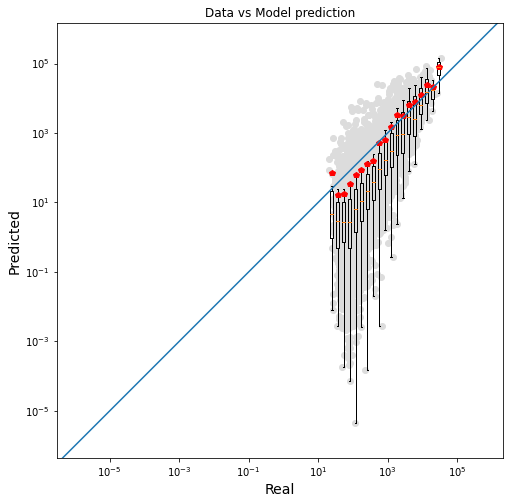

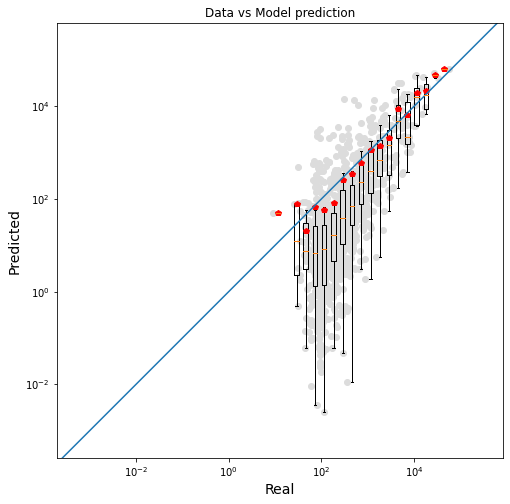

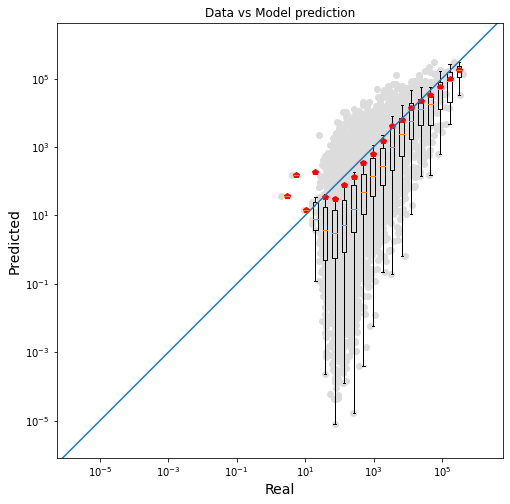

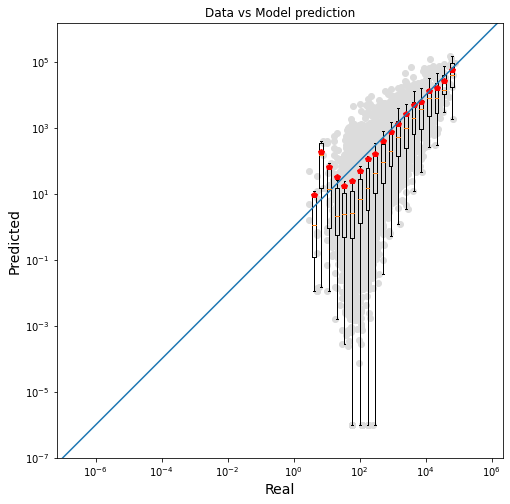

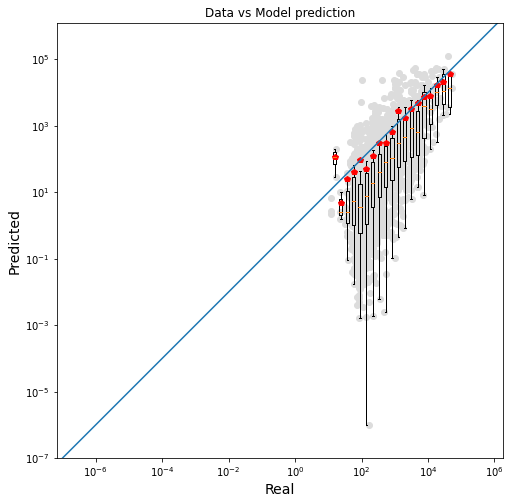

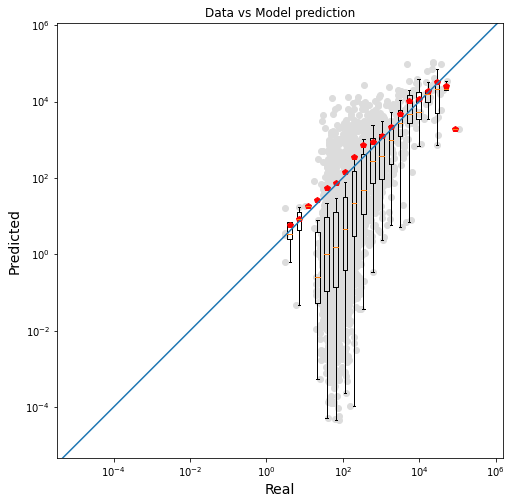

In [6]:
res2={}
def radiation_model(dataset,row,M):
    row=row[1]
    origin=row.name_o
    destination=row.name_d
    T_i=np.sum(dataset[dataset.name_o==origin].total_pop_flow.values)
    m_o=np.sum(dataset[dataset.name_d==origin].total_pop_flow.values)
    m_d=np.sum(dataset[dataset.name_d==destination].total_pop_flow.values)
    M= np.sum(dataset.total_pop_flow.values)
    R=T_i*(m_o*m_d)/((m_o+row.sk)*(m_o+m_d+row.sk))/(1.-m_o/M)
    #R=T_i*((1/(1.+(row.s/row.m_o)))-(1/(1.+((row.s+row.m_d)/row.m_o))))
    if log_flows==True:
        return np.log(R)
    else:
        return R
for i,(key,df) in enumerate(test_list_dataframes.items()):
    test_labels=[]
    predictions=[]
    m1=list_states_dataframes[i][['name_o','m_o']].drop_duplicates(subset = "name_o")
    m2=list_states_dataframes[i][['name_d','m_d']].drop_duplicates(subset = "name_d")
    MM=pd.concat([m1.rename(columns={'name_o': 'name','m_o': 'm'}),m2.rename(columns={'name_d': 'name','m_d': 'm'})],ignore_index=True)
    MM=MM.drop_duplicates(subset = "name")
    M=float(MM['m'].sum())
    print(M)
    for row in df.iterrows():
        test_labels.append(row[1].total_pop_flow)
        predictions.append(radiation_model(list_states_dataframes[i],row,M))
    if log_flows==True:
        predictions=np.exp(predictions)
    print(len(test_labels),len(predictions))
    res2[key]=predictions
    ms.plot_predicted_model(prediction=predictions,real=test_labels,title="Data vs Model prediction",n_box=20,log_scale=True)

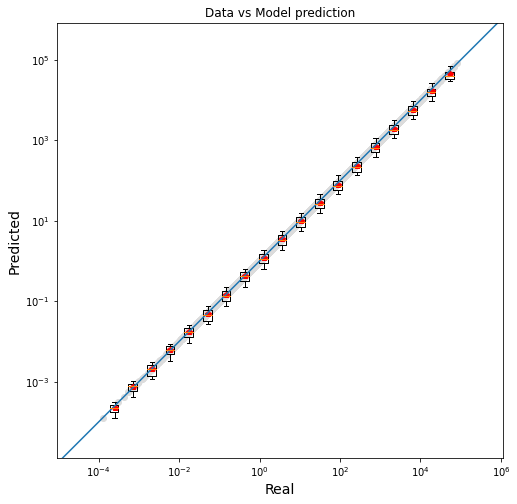

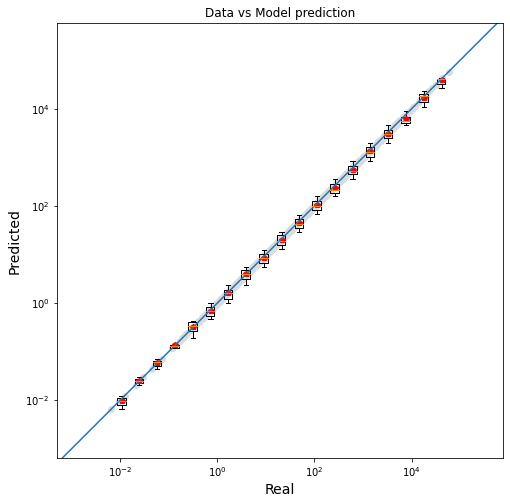

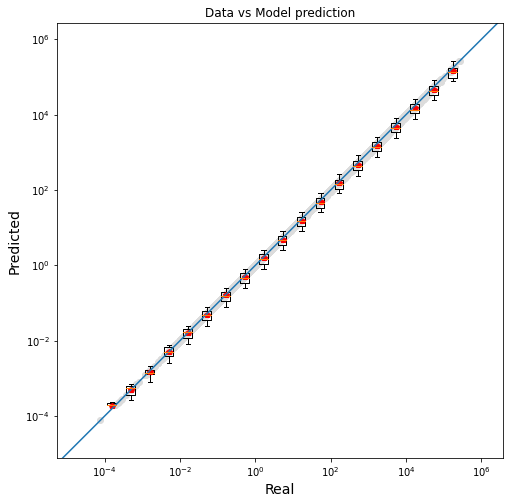

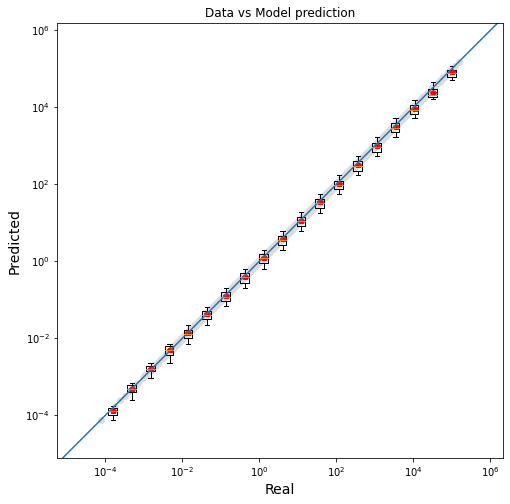

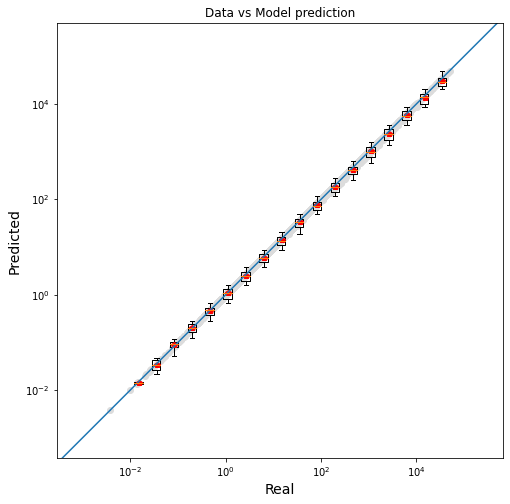

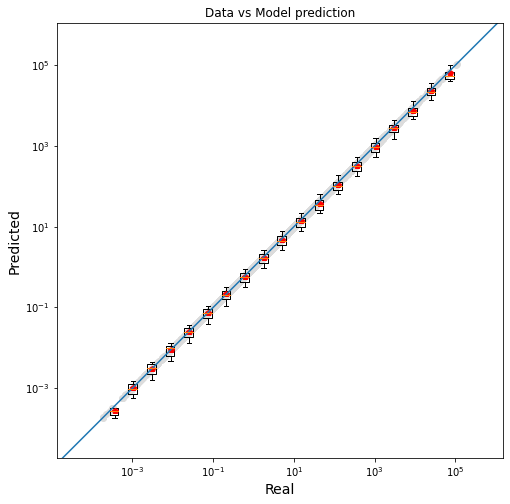

In [7]:
for i in states:
    ms.plot_predicted_model(prediction=res[i],real=res1[i],title="Data vs Model prediction",n_box=20,log_scale=True)

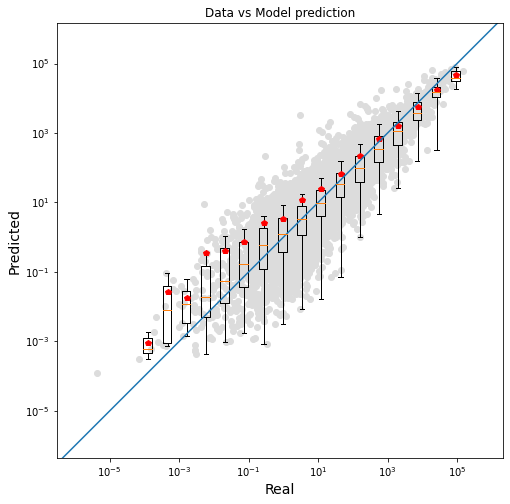

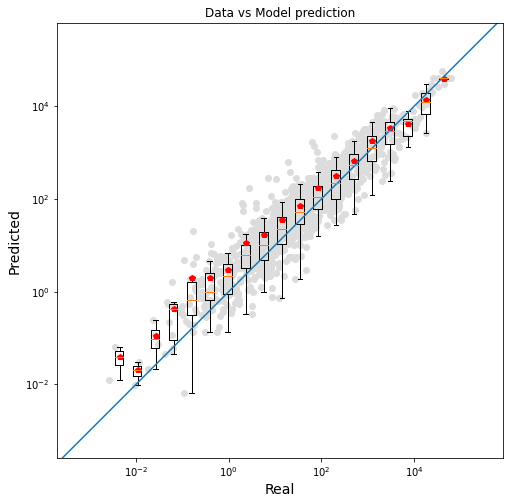

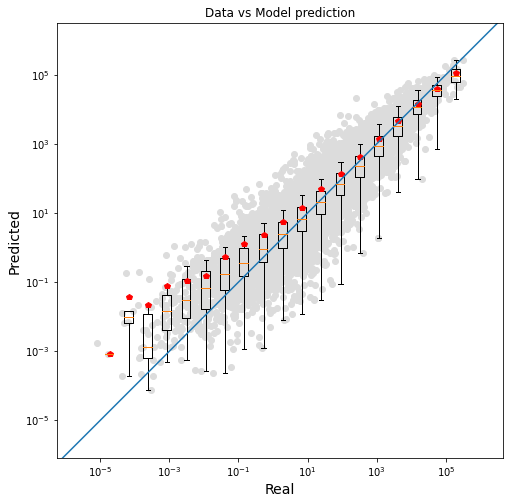

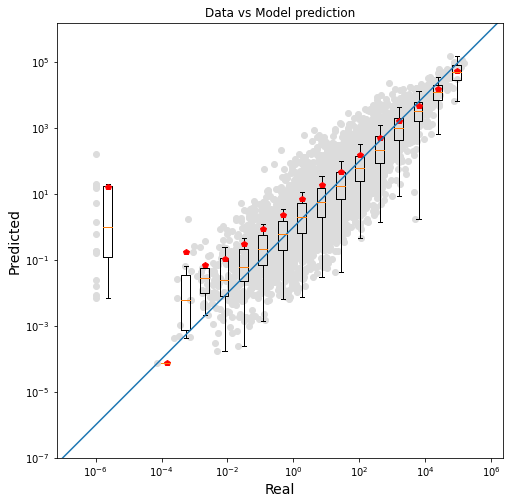

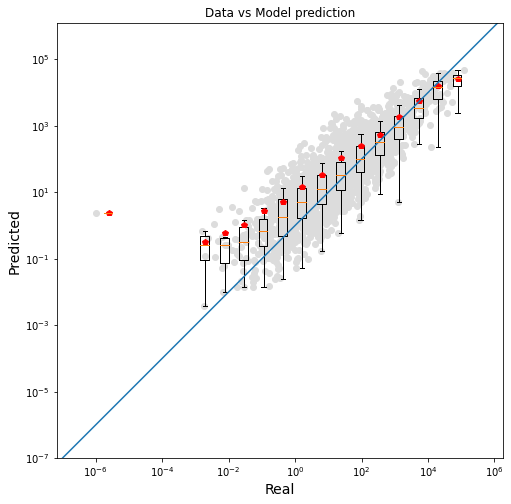

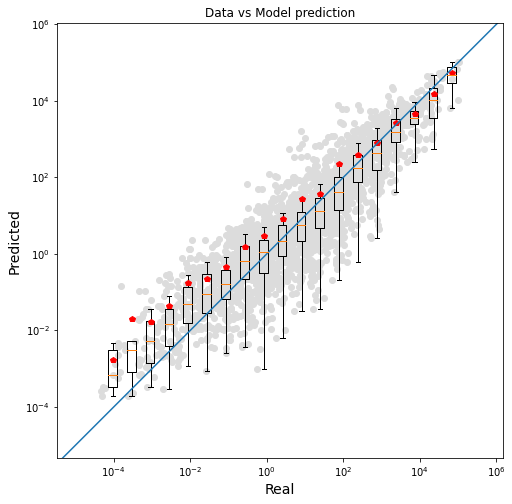

In [8]:
for i in states:
    ms.plot_predicted_model(prediction=res[i],real=res2[i],title="Data vs Model prediction",n_box=20,log_scale=True)

In [9]:
from matplotlib import font_manager
import matplotlib.gridspec as gs
font_dirs = ['Plots/']
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    print(font_file)
    font_manager.fontManager.addfont(font_file)
plt.rc('font', family='Arial')
plt.rcParams['font.family'] = 'Arial'

print(plt.rcParams)

/export/home/shared/Projects/City_flows/Plots/arial.ttf
/export/home/shared/Projects/City_flows/Plots/arialbd.ttf
_internal.classic_mode: False
agg.path.chunksize: 0
animation.bitrate: -1
animation.codec: h264
animation.convert_args: []
animation.convert_path: convert
animation.embed_limit: 20.0
animation.ffmpeg_args: []
animation.ffmpeg_path: ffmpeg
animation.frame_format: png
animation.html: none
animation.writer: ffmpeg
axes.autolimit_mode: data
axes.axisbelow: line
axes.edgecolor: black
axes.facecolor: white
axes.formatter.limits: [-5, 6]
axes.formatter.min_exponent: 0
axes.formatter.offset_threshold: 4
axes.formatter.use_locale: False
axes.formatter.use_mathtext: False
axes.formatter.useoffset: True
axes.grid: False
axes.grid.axis: both
axes.grid.which: major
axes.labelcolor: black
axes.labelpad: 4.0
axes.labelsize: medium
axes.labelweight: normal
axes.linewidth: 0.8
axes.prop_cycle: cycler('color', ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f

0.0 123021.35340946836
0.0 1230213.5340946836


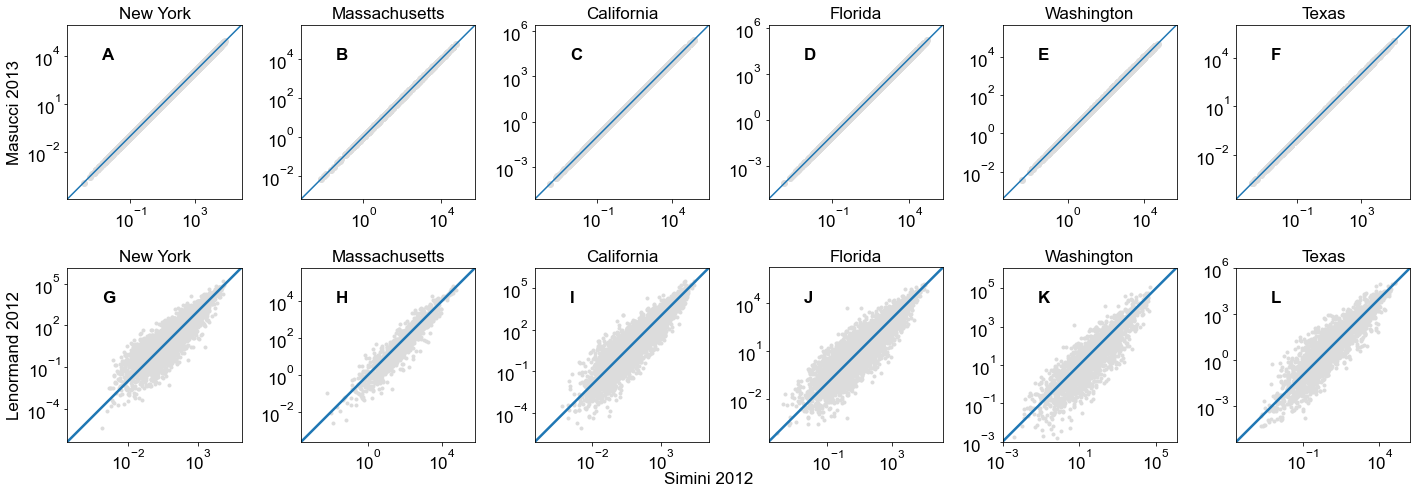

In [12]:
letter='ABCDEFGHIJKLM'
fig = plt.figure(figsize=(20,7))
g = gs.GridSpec(2,6)
offset=0
SMALL_SIZE = 17
MEDIUM_SIZE = 17
BIGGER_SIZE = 17
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('font', family='Arial')
plt.rcParams['font.family'] = 'Arial'
plt.rcParams.update({'font.size': 17})

for i in states:
    ax = fig.add_subplot(g[offset])
    data=res[i]
    data1=res1[i]
    min_xy=min(data+data1)
    max_xy=max(data+data1)
    min_xy=min_xy/10.
    max_xy=max_xy*10.
    ax.plot((min_xy, max_xy), (min_xy,max_xy))
    ax.scatter(data,data1,c='gainsboro')
    #Config
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_title(i)
    ax.text(0.2, 0.8, letter[offset],fontweight='bold',transform=ax.transAxes)
    #
    if offset==0:ax.set_ylabel('Masucci 2013')
    #ax.axis('equal')
    #ax.tick_params(axis = 'both')
    ax.set(adjustable='box', aspect='equal')
    ax.set_xlim(min_xy,max_xy)
    ax.set_ylim(min_xy,max_xy)
    offset+=1
for i in states:
    ax = fig.add_subplot(g[offset])
    data=res[i]
    data1=res2[i]
    min_xy=min(data+data1)
    max_xy=max(data+data1)
    if i=='Washington':
        print(min_xy,max_xy)
    min_xy=min_xy/10.
    max_xy=max_xy*10.
    if i=='Washington':
        print(min_xy,max_xy)
        min_xy=1e-3
    ax.plot(data,data1,'.',c='gainsboro',rasterized=True)
    #ax.scatter(data,data1,c='gainsboro')
    ax.plot((min_xy, max_xy), (min_xy,max_xy),lw=2.5)
    
    #Config
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_title(i)
    #
    ax.text(0.2, 0.8, letter[offset],fontweight='bold',transform=ax.transAxes)
    if offset==6:ax.set_ylabel('Lenormand 2012')
    #ax.axis('equal')
    #ax.tick_params(axis = 'both')
    #ax.set(adjustable='box', aspect='equal')
    ax.set(aspect='equal')
    ax.set_xlim(min_xy,max_xy)
    ax.set_ylim(min_xy,max_xy)
    offset+=1
fig.tight_layout()


fig.supxlabel('Simini 2012')
fig.savefig('./Plots/Radiation_SI_rasterized.pdf',dpi=300)

In [ ]:
color_dict=p.color_dict
chars='ABCDEFGHIJKLMNOPQRSTUVWXYZ'
SMALL_SIZE = 26
MEDIUM_SIZE = 26
BIGGER_SIZE = 26

import matplotlib.cm as cm
import matplotlib.gridspec as gs
mpl.rc('font', family='arial')
sbrn.set(style='ticks', font_scale=2)
colors=[[i/255. for i in color_dict[key]]+[1] for key in models]
colors=colors[::-1]
#SMALL_SIZE = 26
#MEDIUM_SIZE = 26
#BIGGER_SIZE = 26
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('font', family='Arial')
plt.rcParams['font.family'] = 'Arial'
#sbrn.set(style='ticks', font_scale=2)
#fig, axs = plt.subplots(1,len(_dict),figsize=(25, 5),sharey=True)
#plt.gca().set_aspect('equal')
fist_state=list(_dict.keys())[0]
if models==None:
    models=[ k for k in _dict[fist_state].keys() if k!='test']
fig, axs = plt.subplots(len(models),len(_dict),figsize=(25,17.5))#,sharey='col',sharex='col')
plt.rc('font', family='Arial')
sbrn.set(style='ticks', font_scale=2)
fig.supxlabel('Real',va='baseline')
g = gs.GridSpec(4,6)
g.update(wspace=2.0, hspace=0.3)
c_count=0
for i,m in enumerate(models[::-1]):

    if m=='test': continue
    #fig, axs = plt.subplots(1,len(_dict),figsize=(25, 5),sharey=True)#,sharex=True)
    alpha=1.
    #colors = cm.rainbow(np.linspace(0, 1, len(_dict[state])))
    for j,state in enumerate(_dict.keys()):
        t='test'
        if m=='Deep Gravity':
            t='testDG'
        axs[i,j].scatter(_dict[state][t], _dict[state][m],label=m, alpha=0.1,c=[colors[i]])#bar_label(deepcopy(p1), label_type=None)
        if j==0: axs[i,j].set_ylabel(m, fontweight="bold")
        if i==0:
            axs[i,j].set_title(state, fontweight="bold")
        axs[i,j].tick_params(direction='inout', width=2)

        axs[i,j].set_yscale('log')
        axs[i,j].set_xscale('log')
        ratio = 1.0
        alpha=alpha-0.1
    #fig.legend(loc=5)
        xleft, xright = axs[i,j].get_xlim()
        ybottom, ytop = axs[i,j].get_ylim()
        minimum = np.min((axs[i,j].get_xlim(),axs[i,j].get_ylim()))
        maximum = np.max((axs[i,j].get_xlim(),axs[i,j].get_ylim()))
    #ax.set_xlim(minimum*1.2,maximum*1.2)
    #ax.set_ylim(minimum*1.2,maximum*1.2)
    #axs.plot((xleft, xright), (ybottom,ytop))
        axs[i,j].plot(lims, lims)
        axs[i,j].tick_params(axis = 'both')
        #axs[i,j].xticks([])
        if list_ticks!=None:
            axs[i,j].set_xticks(list_ticks)
            axs[i,j].set_yticks(list_ticks)
        if j>0: axs[i,j].set_yticklabels([])
        if i<len(models)-1: axs[i,j].set_xticklabels([])
        axs[i,j].set_xlim(lims)
        axs[i,j].set_ylim(lims)
        axs[i,j].text(.1, .9,chars[c_count], ha='left', va='top',size=30, transform=axs[i,j].transAxes, weight='bold')
        axs[i,j].set(adjustable='box', aspect='equal')
        c_count+=1
    #plt.tight_layout(h_pad=0.3,w_pad=0.3)

fig.tight_layout()
if name!=None:
    fig.savefig(name,format='pdf')
fig.show()